In [2]:
# sub_categories = ["All_Beauty", "Subscription_Boxes", "Magazine_Subscriptions", "Health_and_Personal_Care", "Handmade_Products", "Gift_Cards", "Digital_Music", "Appliances"]
sub_categories = ["Gift_Cards", "Digital_Music", "Magazine_Subscriptions", "Subscription_Boxes"]

In [3]:
from datasets import load_dataset

review_datasets_list = []
meta_dataset_list = []
for sub_cat in sub_categories:
    print(f"Loading review dataset for sub category {sub_cat}")
    sub_cat_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_review_{sub_cat}", split="full", trust_remote_code=True)
    review_datasets_list.append(sub_cat_dataset.add_column('category', [sub_cat]*len(sub_cat_dataset)))
    review_datasets_list.append(sub_cat_dataset)
    
    print(f"Loading metadata dataset for sub category {sub_cat}")
    sub_cat_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_{sub_cat}", split="full", trust_remote_code=True)
    meta_dataset_list.append(sub_cat_dataset)

Loading review dataset for sub category Gift_Cards
Loading metadata dataset for sub category Gift_Cards
Loading review dataset for sub category Digital_Music
Loading metadata dataset for sub category Digital_Music
Loading review dataset for sub category Magazine_Subscriptions
Loading metadata dataset for sub category Magazine_Subscriptions
Loading review dataset for sub category Subscription_Boxes
Loading metadata dataset for sub category Subscription_Boxes


In [4]:
from datasets import concatenate_datasets

In [5]:
review_dataset = concatenate_datasets(review_datasets_list)
meta_dataset = concatenate_datasets(meta_dataset_list)

In [6]:
review_dataset, meta_dataset

(Dataset({
     features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'category'],
     num_rows: 741114
 }),
 Dataset({
     features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
     num_rows: 75706
 }))

In [7]:
meta_dataset = meta_dataset.rename_column("title", "item_title")

In [8]:
meta_dataset[0]

{'main_category': 'Gift Cards',
 'item_title': 'Amazon.com Gift Card in Gift Tag (Various Designs)',
 'average_rating': 4.8,
 'rating_number': 1006,
 'features': ['Gift Card is affixed inside a gift tag',
  'Gift amount may not be printed on Gift Cards',
  'Gift Card has no fees and no expiration date',
  'No returns and no refunds on Gift Cards',
  'Gift Card is redeemable towards millions of items storewide at Amazon.com',
  'Scan and redeem any Gift Card with a mobile or tablet device via the Amazon App',
  'Free One-Day Shipping (where available)',
  'Customized gift message, if chosen at check-out, only appears on packing slip and not on the actual gift card or carrier'],
 'description': ["Amazon.com Gift Cards are the perfect way to give them exactly what they're hoping for - even if you don't know what it is. Amazon.com Gift Cards are redeemable for millions of items across Amazon.com. Item delivered is a single physical Amazon.com Gift Card nested inside or with a free gift acc

In [10]:
len(review_dataset)

741114

In [14]:
review_selected_cols = ["rating", "title", "text", "parent_asin", "user_id", "timestamp", "helpful_vote", "verified_purchase", "category"]
meta_selected_cols = ["main_category", "title", "average_rating", "rating_number", "features", "description", "price", "store", "categories", "details", "parent_asin"]

In [15]:
review_dataset

Dataset({
    features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'category'],
    num_rows: 741114
})

In [16]:
meta_df = meta_dataset.to_pandas()
review_df = review_dataset.to_pandas()

In [17]:
review_selected_cols = ["rating", "title", "text", "parent_asin", "user_id", "timestamp", "helpful_vote", "verified_purchase", "category"]
meta_selected_cols = ["main_category", "item_title", "average_rating", "rating_number", "features", "description", "price", "store", "categories", "details", "parent_asin"]
merge_df = review_df[review_selected_cols].merge(meta_df[meta_selected_cols], on="parent_asin")

In [19]:
merge_df["title_text"] = merge_df.apply(lambda x: f"{x['title']} {x['text']}", axis=1)

In [20]:
len(merge_df)

741114

In [21]:
from datasets.features import Value, Sequence, Features

features = Features({
     'rating': Value(dtype='float64', id=None),
     'title': Value(dtype='string', id=None),
     'title_text': Value(dtype='string', id=None),
     'text': Value(dtype='string', id=None),
     'parent_asin': Value(dtype='string', id=None),
     'user_id': Value(dtype='string', id=None),
     'timestamp': Value(dtype='int64', id=None),
     'helpful_vote': Value(dtype='int64', id=None),
     'verified_purchase': Value(dtype='bool', id=None),
     'main_category': Value(dtype='string', id=None),
     'category': Value(dtype='string', id=None),
     'item_title': Value(dtype='string', id=None),
     'average_rating': Value(dtype='float64', id=None),
     'rating_number': Value(dtype='int64', id=None),
     'features': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'description': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'price': Value(dtype='string', id=None),
     'store': Value(dtype='string', id=None),
     'categories': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'details': Value(dtype='string', id=None)})

In [22]:
from datasets import Dataset, concatenate_datasets
from tqdm.notebook import tqdm

chunk_size = 5000  # Adjust this based on your memory capacity
datasets_list = []

for i in tqdm(range(0, len(merge_df), chunk_size)):
    chunk = merge_df.iloc[i:i + chunk_size]
    datasets_list.append(Dataset.from_pandas(chunk, features))

# Concatenate all chunks into one dataset
final_dataset = concatenate_datasets(datasets_list)

  0%|          | 0/149 [00:00<?, ?it/s]

In [23]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel
from umap import UMAP
import datasets
import numpy as np
import torch

datasets.logging.set_verbosity_error()

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

In [27]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def embed_sentence_pairs(dataloader, tokenizer, model, disable_tqdm=False):
    review_embeddings  = []
    item_embeddings = []
    feature_embeddings = []

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    model.eval()

    loop = tqdm(dataloader, desc=f"Embedding sentences...", disable=disable_tqdm)
    for data in loop:

        review, item = [record['title_text'] for record in data], [record['item_title'] for record in data]
        # print(f"review batch: {review}")
        # encoded_review, encoded_item = (
        #     tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
        #     for sentences in (review, item)
        # )
        encoded_review = tokenizer(review, padding=True, truncation=True, return_tensors='pt')

        # Compute token embeddings
        with torch.no_grad():
            encoded_review = encoded_review.to(device)
            # encoded_item = encoded_item.to(device)
            model_review_output = model(**encoded_review)
            # model_item_output = model(**encoded_item)

        # Perform pooling
        pooled_review = mean_pooling(model_review_output, encoded_review['attention_mask']).cpu().numpy()
        # pooled_item = mean_pooling(model_item_output, encoded_item['attention_mask']).cpu().numpy()
    
        review_embeddings.extend(pooled_review)
        # item_embeddings.extend(pooled_item)

        
    # Concatenate premise and hypothesis embeddings, as well as their absolute difference
    # feature_embeddings = np.concatenate(
    #     [
    #         np.array(review_embeddings),
    #         np.array(item_embeddings),
    #         np.abs(np.array(review_embeddings) - np.array(item_embeddings))
    #     ],
    #     axis=1
    # )
    feature_embeddings = np.array(review_embeddings)
    # feature_embeddings = normalize(feature_embeddings, norm='l2', axis=1)
    return feature_embeddings

In [26]:
cat = "Magazine_Subscriptions"
cat_dataset = final_dataset.filter(lambda x: x["category"] == cat)
cat_dataset

Filter:   0%|          | 0/741114 [00:00<?, ? examples/s]

Dataset({
    features: ['rating', 'title', 'title_text', 'text', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'main_category', 'category', 'item_title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'store', 'categories', 'details'],
    num_rows: 71497
})

In [ ]:
model_name = 'sentence-transformers/all-MiniLM-L6-v2'

# Uncomment the following line to try a regular Transformers model trained on MultiNLI
# model_name = 'sileod/roberta-base-mnli'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

batch_size = 128

# Place Hugging Face datasets in a PyTorch DataLoader
loader = DataLoader(cat_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

# Get embeddings
embeddings = embed_sentence_pairs(loader, tokenizer, model, disable_tqdm=False)

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Embedding sentences...:   0%|          | 0/559 [00:00<?, ?it/s]

In [24]:
emb_size = 384
text_embeddings = embeddings[:,:emb_size]

NameError: name 'embeddings' is not defined

In [ ]:
import numpy as np

# import matplotlib.pyplot as plt
# for the cluster to save the fig:
import matplotlib
matplotlib.use('Agg')

from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle as sh

from em import em, mv

# framework: outlier or novelty detection
novelty_detection = True

# parameters of the algorithm:
averaging = 100
max_features = 10
n_generated = 100000
alpha_min = 0.9
alpha_max = 0.999
t_max = 0.9
ocsvm_max_train = 10000

np.random.seed(1)

n_samples, n_features = embeddings.shape
n_samples_train = n_samples // 2
n_samples_test = n_samples - n_samples_train

X_train = embeddings[:n_samples_train, :]
X_test = embeddings[n_samples_train:, :]

# define models:
iforest = IsolationForest()
# lof = LocalOutlierFactor(n_neighbors=20, novelty=False)
ocsvm = OneClassSVM()

n_samples, n_features = X_test.shape
em_iforest, mv_iforest = 0, 0
em_lof, mv_lof = 0, 0
em_ocsvm, mv_ocsvm = 0, 0
nb_exp = 0
while nb_exp < averaging:
    features = sh(np.arange(n_features))[:max_features]
    X_train_ = X_train[:, features]
    X_ = X_test[:, features]

    lim_inf = X_.min(axis=0)
    lim_sup = X_.max(axis=0)
    volume_support = (lim_sup - lim_inf).prod()
    if volume_support > 0:
        nb_exp += 1
        t = np.arange(0, 100 / volume_support, 0.001 / volume_support)
        axis_alpha = np.arange(alpha_min, alpha_max, 0.001)
        unif = np.random.uniform(lim_inf, lim_sup,
                                 size=(n_generated, max_features))

        iforest.fit(X_train_)
        # lof.fit(X_train_)
        ocsvm.fit(X_train_[:min(ocsvm_max_train, n_samples_train - 1)])
        print('end of ocsvm training!')
        s_X_iforest = iforest.decision_function(X_)
        # s_X_lof = lof.decision_function(X_)
        s_X_ocsvm = ocsvm.decision_function(X_).reshape(1, -1)[0]

        s_unif_iforest = iforest.decision_function(unif)
        # s_unif_lof = lof.decision_function(unif)
        s_unif_ocsvm = ocsvm.decision_function(unif).reshape(1, -1)[0]

        em_iforest += em(t, t_max, volume_support, s_unif_iforest,
                         s_X_iforest, n_generated)[0]
        mv_iforest += mv(axis_alpha, volume_support, s_unif_iforest,
                         s_X_iforest, n_generated)[0]
        # em_lof += em(t, t_max, volume_support, s_unif_lof, s_X_lof,
        #              n_generated)[0]
        # mv_lof += mv(axis_alpha, volume_support, s_unif_lof,
        #              s_X_lof, n_generated)[0]
        em_ocsvm += em(t, t_max, volume_support, s_unif_ocsvm,
                       s_X_ocsvm, n_generated)[0]
        mv_ocsvm += mv(axis_alpha, volume_support, s_unif_ocsvm,
                       s_X_ocsvm, n_generated)[0]

em_iforest /= averaging
mv_iforest /= averaging
# em_lof /= averaging
# mv_lof /= averaging
em_ocsvm /= averaging
mv_ocsvm /= averaging

with open('result_em_bench_high_unsupervised_with' + str(alpha_min) + '_factorized_with' + str(ocsvm_max_train) + 'ocsvm_' + str(max_features) + '_' + str(averaging) + '_' + '.txt', 'a') as result:
    result.write('em_iforest = ' + str(em_iforest) + '\n')
    # result.write('em_lof = ' + str(em_lof) + '\n')
    result.write('em_ocsvm = ' + str(em_ocsvm) + '\n \n')

    result.write('mv_iforest = ' + str(mv_iforest) + '\n')
    # result.write('mv_lof = ' + str(mv_lof) + '\n')
    result.write('mv_ocsvm = ' + str(mv_ocsvm) + '\n')

In [26]:
from cleanlab.outlier import OutOfDistribution

# Get outlier scores for each of the data feature embeddings
ood = OutOfDistribution()
outlier_scores = ood.fit_score(features=text_embeddings)

Fitting OOD estimator based on provided features ...


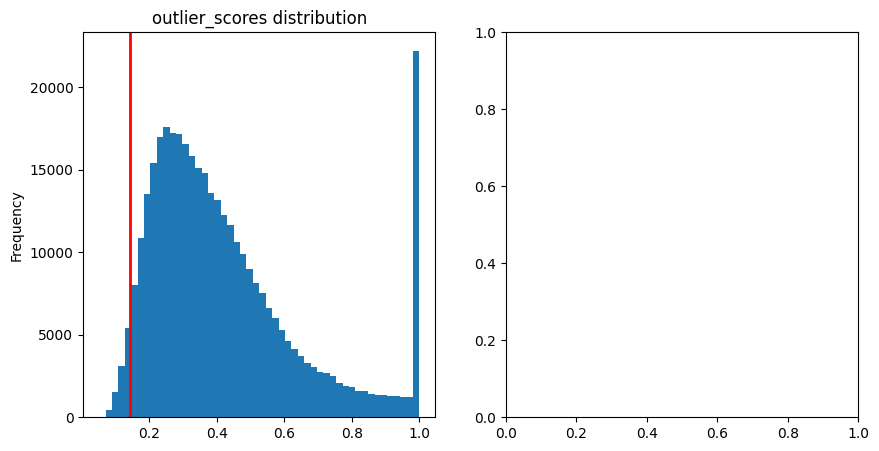

In [27]:
import matplotlib.pyplot as plt

threshold = np.percentile(outlier_scores, 2.5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt_range = [outlier_scores.min(), outlier_scores.max()]

axes[0].hist(outlier_scores, range=plt_range, bins=50)
axes[0].set(title='outlier_scores distribution', ylabel='Frequency')
axes[0].axvline(x=threshold, color='red', linewidth=2)

In [28]:
sorted_ids = outlier_scores.argsort()
outlier_scores = outlier_scores[sorted_ids]
outlier_ids = sorted_ids[outlier_scores < threshold]

selected_outlier_subset = sample_dataset.select(outlier_ids)
selected_outlier_subset.to_pandas().tail(15)

NameError: name 'sample_dataset' is not defined